![](assets/demo_output_cropped.png) 

# ECE 046211 - Technion - Deep Learning

## Project - DSP in Deep Learning – CW (carrier wave) Detector + Decoder

<img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline">

### Students Information

---

| Name      |Campus Email| ID  |
|-----------|-------------------------------|----------|
| Student 1 | maor.asyag@campus.technion.ac.il | 318550746 |
| Student 2 | elirazkadosh@campus.technion.ac.il | 315675090 |
| Student 3 | eliramamrusi@campus.technion.ac.il | 319040325 |

<img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline">

### Summary

---
* **General**
    * Implementation in pytorch
    * Digital signal processing from scratch
    * Generating training samples (morse signals -> spectrogram) on-the-fly with various hyperparameters
    * Morse signals varies in **pitch** (main frequency), **length** (number of chars), **signal amplitude**, noise amplitude (**SNR** [dB]), morse **dit\dah length**
    * Used **TensorBoard** for local training tracking
    
* **Part 1: LSTM-RNN morse decoder**
    * input: spectrogram [shape: (dynamic, 21)] + target string, output: string
    * Model size: 740,395 parameters
    * trained on ~50,000,000 morse chars
    * Average CER (Character Error Rate) <2% on SNR above -5dB
    * loss function: CTCLoss
        * The Connectionist Temporal Classification loss. Calculates loss between a continuous (unsegmented) time series and a target sequence.
    * Train loss: 0.15
    * Fixed vs Dynamic pitch (main frequency) - Model training on fixed frequency performed better in evaluation
       
* **Part 2: FASTER RCNN (resnet50) morse object detection**
    * input: spectrogram [shape: (dynamic, 21)] , output: bounding box, scores, labels
    * Bounding box prediction
    * Trained on ~1,000,000 spectrogram's
    * Model size:
        * Total number of parameters: 41,299,161
        * Number of trainable parameters: 41,076,761
    * Accuracy: IoU-x axis 97%
    * loss function: [RPN Loss Function](https://towardsdatascience.com/review-faster-r-cnn-object-detection-f5685cb30202), combines:
        * classification loss over 2 classes
        * regression loss of bounding boxes
    * Train loss: 0.12, Validation loss: 0.3  

<img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline">

### Morse Code

---

Morse code is a method of transmitting text information using a series of short and long signals, called "dits" and "dahs" respectively. The basic unit of time measurement in Morse code is the "dit," and the "dah" is equal to three dits in duration. The spacing between dits and dahs within a character is equal to one dit. The spacing between characters within a word is equal to three dits, and the spacing between words is equal to seven dits.

Here's an image that illustrates the structure of Morse code:

<img src="assets/International_Morse_Code.png" style="height: 200px;"/>

The image shows the relative timing of dits, dahs, and the spacing between them. As you can see, a "dah" is three times longer than a "dit," and the spacing within a character is one dit, between characters is three dits, and between words is seven dits.

For example, the letter "A" is represented by ".-" in Morse code, which corresponds to a dit (left) followed by a dah (right). The letter "Q" is represented by "--.-", which corresponds to two dahs (right, right), a dit (left), and a dah (right).

# Imports

In [1]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import logging
import sys
from scipy import signal
import torch
import os
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from itertools import groupby
# !pip install Levenshtein # uncomment in Colab
from Levenshtein import distance
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
import random
import warnings

# Configs
logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.DEBUG,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
log = logging.getLogger('')
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("librosa").setLevel(logging.INFO)
warnings.filterwarnings("ignore", message=".*complex*")

%load_ext tensorboard

# Morse

## Morse Utils

In [3]:
MORSE_CODE_DICT = {
    'A': '.-',
    'B': '-...',
    'C': '-.-.', 
    'D': '-..',
    'E': '.',
    'F': '..-.',
    'G': '--.',
    'H': '....',
    'I': '..',
    'J': '.---',
    'K': '-.-',
    'L': '.-..',
    'M': '--',
    'N': '-.',
    'O': '---',
    'P': '.--.',
    'Q': '--.-',
    'R': '.-.',
    'S': '...',
    'T': '-',
    'U': '..-',
    'V': '...-',
    'W': '.--',
    'X': '-..-',
    'Y': '-.--',
    'Z': '--..',
    '1': '.----',
    '2': '..---',
    '3': '...--',
    '4': '....-',
    '5': '.....',
    '6': '-....',
    '7': '--...',
    '8': '---..',
    '9': '----.',
    '0': '-----',
    '.': '.-.-.-',
    ',': '--..--',
    '?': '..--..',
    '=': '-...-',
    '+': '.-.-.',
}
ALPHABET = " " + "".join(MORSE_CODE_DICT.keys())
num_tags = len(ALPHABET)
sr = 2000 # sample rate, affect spectrum size

def get_spectrogram(samples, sr):
    """
    Calculate the spectrogram of a time series signal with sample rate sr
    :param samples: time domain signal
    :param sr: sample rate
    :return: 
    """
    _, _, sxx = signal.spectrogram(samples, nperseg=int(0.02 * sr) , noverlap=0)
    return sxx


def aggregate_cer(prev_cer, prev_total_chars, y, y_pred):
    """
    Calculate new CER (Character Error Rate) given previous CER and new data points [y, y_pred]
    :param prev_cer: previous CER, from .0 to 1.0
    :param prev_total_chars: total chars (int)
    :param y: series of chars (tokens)
    :param y_pred: target chars
    :return: new CER
    """
    new_cer = prev_cer
    new_total_chars = prev_total_chars

    for i in range(len(y)):
        a = prediction_to_str(y[i])
        b = prediction_to_str(torch.argmax(y_pred[i], 1))
        new_cer = calculate_levenshtein_distance(new_cer, new_total_chars, a, b)
        new_total_chars += max(len(a), len(b))

    return new_cer, new_total_chars


def calculate_levenshtein_distance(prev_cer, prev_total_chars, original, predicted):
    """
    Calculate CER based on Levenshtein distance
    :param prev_cer: 0.0 to 1.0
    :param prev_total_chars: int
    :param original: target string
    :param predicted: predicted string
    :return: 
    """
    d = distance(original, predicted)
    new_total_chars = prev_total_chars + max(len(original), len(predicted))

    return (prev_cer * prev_total_chars + d) / new_total_chars


def calculate_cer(prev_cer, prev_total_chars, original, predicted):
    """
    Computes the Character Error Rate (CER) between the original and predicted strings
    :param prev_cer: 
    :param prev_total_chars: 
    :param original: 
    :param predicted: 
    :return: new CER
    """
    # Convert strings to lists of characters
    original_chars = list(original)
    predicted_chars = list(predicted)

    # Get the length of the longer string
    max_length = max(len(original_chars), len(predicted_chars))

    # Initialize counters
    errors = 0

    # Iterate over the characters and count errors
    for i in range(max_length):
        try:
            if original_chars[i] != predicted_chars[i]:
                errors += 1
        except IndexError:
            # If the string is shorter, consider the remaining characters as errors
            errors += 1

    if errors > 0:
        log.error(original, predicted, errors)

    return (prev_cer * prev_total_chars + errors) / (prev_total_chars + max_length)

def find_one_first_element(ndarrays):
    """
    Find the first and last array that contains ones (bounding the activity in a spectrogram)
    :param ndarrays: spectrogram
    :return: 
    """
    first_index = -1
    last_index = -1
    for i, arr in enumerate(ndarrays):
        if arr[0] == 1:
            if first_index == -1:
                first_index = i
            last_index = i
    return first_index, last_index


def accumulated_length(array_list, start_index, end_index):
    """
    Given a list of time-series values (represents morse chars), return the accumulated length in the time domain
    :param array_list: 
    :param start_index: 
    :param end_index: 
    :return: 
    """
    acc_length_start = 0
    for i in range(start_index):
        acc_length_start += len(array_list[i])

    acc_length_end = acc_length_start
    for i in range(start_index, end_index + 1):
        acc_length_end += len(array_list[i])

    return acc_length_start, acc_length_end


def get_signal_bbx(signal_array, spec_time_len, signal_len, pitch):
    """
    Get signal boundary box
    :param signal_array:
    :param spec_time_len:
    :param signal_len:
    :return: x_start, y_start, x_end, y_end
    """
    activity_array_start_idx, activity_array_end_idx = find_one_first_element(signal_array)
    time_domain_start_idx, time_domain_end_idx = accumulated_length(signal_array, activity_array_start_idx,
                                                                    activity_array_end_idx)
    alpha = signal_len // spec_time_len
    bbx_idx_start_x = time_domain_start_idx // alpha
    bbx_idx_end_x = time_domain_end_idx // alpha

    main_freq_idx = pitch*2 // 100
    return bbx_idx_start_x, main_freq_idx, bbx_idx_end_x, main_freq_idx+1


def apply_noise_to_signal(signal, SNRdb):
    """
    Apply noise to signal
    :param signal: 
    :param SNRdb: specific SNR (Signal to Noise ratio)
    :return: 
    """
    signal_power = np.mean(abs(signal ** 2))
    sigma2 = signal_power * 10 ** (-SNRdb / 10)  # calculate noise power based on signal power and SNR
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

def get_dot(ref, apply_random_length_dots):
    if apply_random_length_dots:
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(ref * scale)
    else:
        return int(ref)

def get_dash(ref, apply_random_length_dots):
    if apply_random_length_dots:
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(3 * ref * scale)
    else:
        return int(3 * ref)


## Morse Generator

In [4]:
def generate_morse_sample(sr=2000, text_len=10, pitch=950, wpm=18, snrDB=1, amplitude=100, s=None, apply_random_length_dots = True):
    """
    Generate morse sample
    :param apply_random_length_dots: 
    :param sr: 
    :param text_len: 
    :param pitch: 
    :param wpm: 
    :param snrDB: 
    :param amplitude: 
    :param s: specific string
    :return: <time domain signal, frequency domain spectrogram, morse string, spectrogram bounding box>
    """
    assert pitch < sr / 2  # Nyquist

    # Common morse spacing [https://en.wikipedia.org/wiki/Morse_code]
    ref = (60 / wpm) / 50 * sr

    # Create random string that doesn't start or end with a space
    if s is None:
        s1 = ''.join(random.choices(ALPHABET, k=text_len - 2))
        s2 = ''.join(random.choices(ALPHABET[1:], k=2))
        s = s2[0] + s1 + s2[1]

    time_domain_signal = []
    time_domain_signal.append(np.zeros(5 * get_dot(ref, apply_random_length_dots)))

    # dat\dit space = 1 dot, char space = 3 dots, word space = 7 dots
    for c in s:
        if c == ' ':
            time_domain_signal.append(np.zeros(7 * get_dot(ref, apply_random_length_dots)))
        else:
            for m in MORSE_CODE_DICT[c]:
                if m == '.':
                    time_domain_signal.append(np.ones(get_dot(ref, apply_random_length_dots)))
                    time_domain_signal.append(np.zeros(get_dot(ref, apply_random_length_dots)))
                elif m == '-':
                    time_domain_signal.append(np.ones(get_dash(ref, apply_random_length_dots)))
                    time_domain_signal.append(np.zeros(get_dot(ref,apply_random_length_dots)))

            time_domain_signal.append(np.zeros(2 * get_dot(ref, apply_random_length_dots)))

    time_domain_signal.append(np.zeros(5 * get_dot(ref, apply_random_length_dots)))
    time_domain_signal_ = time_domain_signal.copy()
    time_domain_signal = np.hstack(time_domain_signal)

    # Modulation
    t = np.arange(len(time_domain_signal)) / sr
    sine = np.sin(2 * np.pi * t * pitch)
    time_domain_signal = sine * time_domain_signal

    # Add noise
    time_domain_signal = apply_noise_to_signal(time_domain_signal, snrDB)
    time_domain_signal *= amplitude / 100
    time_domain_signal = np.clip(time_domain_signal, -1, 1)
    time_domain_signal = time_domain_signal.astype(np.float32)

    # calculate spectrum
    spec = get_spectrogram(time_domain_signal, sr=sr)

    # calculate spec boundaries
    bbx = get_signal_bbx(time_domain_signal_, spec.shape[1], len(time_domain_signal), pitch)

    return time_domain_signal, spec, s, bbx

## Example generating 1 signal

2024-04-02 10:03:03 [INFO] root - pitch: 350, wpm: 18, snrDB: 9, amplitude: 76, str: Z7=VF, bbx: (13, 7, 244, 8)


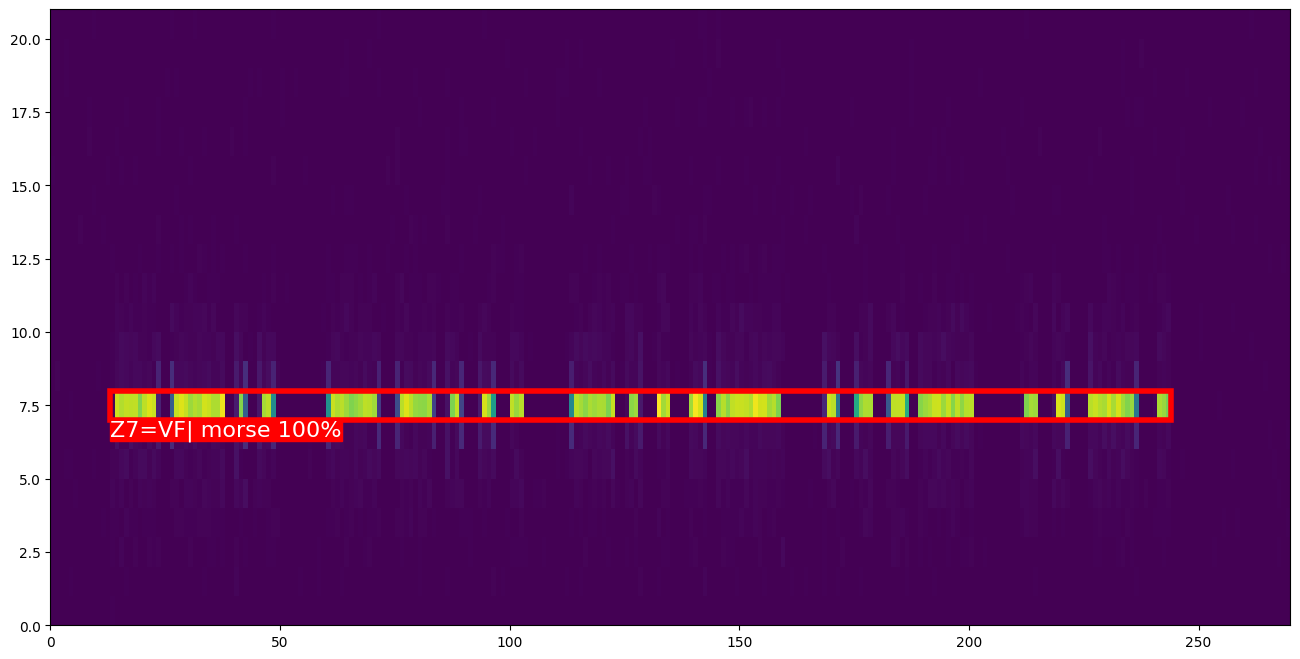

In [10]:
# Params
sr = 2000
length = random.randrange(1, 8)
pitch = random.randint(2, 19) * 50
wpm = 18
snrDB = random.randrange(-10, 10)
amplitude = random.randrange(50, 200)

time_domain_signal, spec, y, bbx = generate_morse_sample(sr, length, pitch, wpm, snrDB, amplitude, None)
log.info(f"pitch: {pitch}, wpm: {wpm}, snrDB: {snrDB}, amplitude: {amplitude}, str: {y}, bbx: {bbx}")

# Display spectrogram
min_value = np.min(spec)
max_value = np.max(spec)
normalized_spectrum = (spec - min_value) / (max_value - min_value)

fig, ax = plt.subplots(1, figsize=(16, 8))
plt.pcolormesh(normalized_spectrum)
rect = patches.Rectangle(
    (bbx[0], bbx[1]),
    bbx[2]-bbx[0],
    bbx[3]-bbx[1],
    linewidth=4,
    edgecolor='red',
    facecolor="none",
)
# Add the patch to the Axes
ax.add_patch(rect)
plt.text(
    bbx[0], bbx[1],
    s=y + '| morse' + " " + str(int(100*1)) + "%",
    color="white",
    fontsize=16,
    verticalalignment="top",
    bbox={"color": 'red', "pad": 0},
)
plt.show()

# Save file
filename = f'./assets/test.wav'
time_domain_signal = np.int16(time_domain_signal / np.max(np.abs(time_domain_signal)) * 32000)
wavfile.write(filename, sr, time_domain_signal)
Audio(filename)

# Models

## Decoder: LSTM RNN

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that has been widely used for sequence-to-sequence tasks, such as machine translation, speech recognition, and, in our case, decoding Morse code from a spectrogram.

**Spectrogram Representation**

Before feeding the data into the LSTM, we need to represent the Morse code signal as a spectrogram. A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary with time. It is a 2D image-like representation, where the x-axis represents time, the y-axis represents frequency, and the intensity of each pixel represents the energy or amplitude of the signal at that particular time and frequency.

**LSTM Architecture**

The LSTM network is designed to process sequential data, such as the spectrogram representation of Morse code. It consists of a series of interconnected memory cells, which are capable of maintaining and updating their internal state over time. This allows the LSTM to selectively remember or forget information from previous time steps, making it well-suited for tasks that require long-term dependencies.

Our LSTM architecture typically consists of the following components:

1. **Input Layer**: This layer receives the input data, which in our case is the spectrogram of the Morse code signal.
2. 3 More **Dense Layers**
3. Dropuout Layer after most of the Dense Layers
2. **LSTM Layer**: One LSTM layer to process the input sequence
4. **Output Layer**: The final layer produces the predicted output sequence, which is the decoded text.

**Training and Decoding**

During training, the LSTM network is fed with pairs of spectrogram representations and their corresponding text transcriptions. The network learns to map the input spectrograms to the correct text sequences by adjusting its weights and biases through backpropagation and optimization algorithms like stochastic gradient descent.

During decoding (inference), the trained LSTM model takes a new spectrogram as input and generates the predicted text sequence by iteratively processing the input and updating its internal state. Techniques like beam search or greedy decoding can be employed to find the most likely text sequence given the input spectrogram.

**Advantages of LSTM for Morse Code Decoding**

LSTM networks are well-suited for decoding Morse code from spectrograms due to the following reasons:

1. **Sequence Processing**: LSTM can handle variable-length input sequences, making it suitable for processing Morse code signals of different durations.
2. **Long-Term Dependencies**: LSTM can capture long-term dependencies in the input data, which is important for correctly decoding Morse code characters that may be separated by various timing gaps.
3. **Robustness to Noise**: LSTM networks can learn to be robust to noise and variations in the input data, which is crucial for decoding Morse code signals that may be corrupted by environmental factors or imperfect transmission.

Overall, the LSTM architecture, combined with the spectrogram representation of Morse code signals, provides a powerful and effective approach for decoding Morse code sequences from audio or radio signals.


### Tokenizer

In [11]:
# 0: blank label
tag_to_idx = {c: i + 1 for i, c in enumerate(ALPHABET)}
idx_to_tag = {i + 1: c for i, c in enumerate(ALPHABET)}

### Utils

In [12]:
def prediction_to_str(seq):
    """
    LSTM tokenize output to string
    :param seq: 
    :return: predicted utf-8 string
    """
    if not isinstance(seq, list):
        seq = seq.tolist()

    seq = [i[0] for i in groupby(seq)]  # remove duplicates
    seq = [s for s in seq if s != 0]  # remove blanks
    seq = "".join(idx_to_tag[c] for c in seq)  # convert to string
    seq = seq.rstrip()

    return seq


def get_training_sample(*args, **kwargs):
    """
    Generate training morse sample
    :param args: 
    :param kwargs: 
    :return: <spectrogram, tokenized target string>
    """
    _, spec, y, _ = generate_morse_sample(*args, **kwargs)

    spec = torch.from_numpy(spec)
    spec = spec.permute(1, 0)

    y_tags = [tag_to_idx[c] for c in y]
    y_tags = torch.tensor(y_tags)

    return spec, y_tags


def collate_fn_pad(batch):
    """
    Batching helper
    :param batch: 
    :return: 
    """
    xs, ys = zip(*batch)

    input_lengths = torch.tensor([t.shape[0] for t in xs])
    output_lengths = torch.tensor([t.shape[0] for t in ys])

    seqs = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys = nn.utils.rnn.pad_sequence(ys, batch_first=True)

    return input_lengths, output_lengths, seqs, ys

### Model Architecture

In [13]:
class LSTMRnn(nn.Module):
    def __init__(self, num_tags, spectrogram_size):
        super(LSTMRnn, self).__init__()

        num_tags = num_tags + 1  # 0: blank
        hidden_dim = 256
        lstm_dim1 = 256

        self.dense1 = nn.Linear(spectrogram_size, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.dense4 = nn.Linear(hidden_dim, lstm_dim1)
        self.lstm1 = nn.LSTM(lstm_dim1, lstm_dim1, batch_first=True)
        self.dense5 = nn.Linear(lstm_dim1, num_tags)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        x, _ = self.lstm1(x)
        x = self.dense5(x)
        x = F.log_softmax(x, dim=2)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Dataset

In [192]:
class Dataset(data.Dataset):
    """
    Custom PyTorch dataset for lstm morse decoder task
    Generates data samples in runtime
    """
    def __init__(self, number_of_samples=2048, sr=2000, explicit_snr=None):
        self.length = number_of_samples
        self.sr = sr
        self.explicit_snr = explicit_snr

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        length = random.randrange(10, 20)  # 10,20
        pitch = 950
        wpm = 18
        amplitude = random.randrange(50, 200)
        if self.explicit_snr != None:
            snrDB = self.explicit_snr
        else:
            snrDB = random.randrange(-10, 10)
            
        return get_training_sample(self.sr, length, pitch, wpm, snrDB, amplitude, None, None)

### Training
launch tensorboard with CLI
tensorboard --logdir C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs

In [163]:
tf_board_log_dir_path = "C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs"  # path without hebrew unicode chars
batch_size = 64
spectrogram_size = generate_morse_sample(sr=2000)[1].shape[0]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
writer = SummaryWriter(tf_board_log_dir_path)

# Set up trainer & evaluator
model = LSTMRnn(num_tags, spectrogram_size).to(device)
log.info("Number of params", model.count_parameters())

# Lower learning rate to 1e-4 after about 1500 epochs
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
ctc_loss = nn.CTCLoss()

train_loader = torch.utils.data.DataLoader(
    Dataset(number_of_samples=2048),
    batch_size=batch_size,
    collate_fn=collate_fn_pad,
)

random.seed(0)

# run_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_date = '2024-03-31_23-29-30'
epoch = 1100
epochs = epoch + 0
losses = []

# Resume training
if epoch != 0:
    model.load_state_dict(torch.load(f"models/{run_date}_{epoch:06}.pt", map_location=device))
    # state_dict = torch.load(f"models/{run_date}_{epoch:06}.pt")
    # model.dense1.weight = torch.nn.Parameter(state_dict["dense1.weight"])
    # model.dense1.bias = torch.nn.Parameter(state_dict["dense1.bias"])
    # model.dense2.weight = torch.nn.Parameter(state_dict["dense2.weight"])
    # model.dense2.bias = torch.nn.Parameter(state_dict["dense2.bias"])
    # model.dense3.weight = torch.nn.Parameter(state_dict["dense3.weight"])
    # model.dense3.bias = torch.nn.Parameter(state_dict["dense3.bias"])
    # model.dense4.weight = torch.nn.Parameter(state_dict["dense4.weight"])
    # model.dense4.bias = torch.nn.Parameter(state_dict["dense4.bias"])
    # model.dense5.weight = torch.nn.Parameter(state_dict["dense5.weight"])
    # model.dense5.bias = torch.nn.Parameter(state_dict["dense5.bias"])
    # model.lstm1.weight_ih_l0.data = torch.nn.Parameter(state_dict["lstm1.weight_ih_l0"])
    # model.lstm1.weight_hh_l0.data = torch.nn.Parameter(state_dict["lstm1.weight_hh_l0"])
    # model.lstm1.bias_ih_l0.data = torch.nn.Parameter(state_dict["lstm1.bias_ih_l0"])
    # model.lstm1.bias_hh_l0.data = torch.nn.Parameter(state_dict["lstm1.bias_hh_l0"])
    log.info(f'Model has been loaded from prev state of epoch: {epoch}')

model.train()
while epoch < epochs:
    train_loss = 0
    curr_cer = 1.0
    total_chars = 0

    for (input_lengths, output_lengths, x, y) in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        # print(x.shape)
        y_pred = model(x)

        m = torch.argmax(y_pred[0], 1)
        curr_cer, total_chars = aggregate_cer(curr_cer, total_chars, y, y_pred)
        y_pred = y_pred.permute(1, 0, 2)

        loss = ctc_loss(y_pred, y, input_lengths, output_lengths)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    writer.add_scalar(f"training/{run_date}_loss", train_loss / len(train_loader), epoch)
    writer.add_scalar(f"training/{run_date}_lvstn", curr_cer * 100, epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{run_date}_{epoch:06}.pt")

    losses.append(train_loss / len(train_loader))
    log.info(
        f'Epoch #{epoch}| (e.g. target: {prediction_to_str(y[0])}, pred: {prediction_to_str(m)}), loss: {loss.item():2f}, CER: {curr_cer * 100:1f}% on {total_chars} chars')
    epoch += 1

2024-04-01 09:28:53 [INFO] root - Model has been loaded from prev state of epoch: 1100


C:\Users\Maor\AppData\Local\Temp\ipykernel_31128\3015226362.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  time_domain_signal = time_domain_signal.astype(np.float32)
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Maor\AppData\Local\Programs\Python\Python39\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Maor\AppData\Local\Programs\Python\Python39\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Maor\AppData\Local\Programs\Python\Python39\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Maor\AppData\Local\Programs\Python\Python39\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Maor\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_ma

### Evaluation loop vs SNR

In [164]:
snrs = [-15, -10, -5, 0, 5, 10, 15]
cers = []
val_losses = []

for i in range(len(snrs)):
    print('Validating model for snr: ', snrs[i])

    val_loader = torch.utils.data.DataLoader(
        Dataset(number_of_samples=2048, sr=2000, explicit_snr=snrs[i]),
        batch_size=batch_size,
        collate_fn=collate_fn_pad,
    )
    val_loss = 0.0
    curr_cer = 1.0
    total_chars = 0

    model.eval()
    with torch.no_grad():
        for (input_lengths, output_lengths, x, y) in val_loader:
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_pred = model(x)

            # Compute loss
            m = torch.argmax(y_pred[0], 1)
            curr_cer, total_chars = aggregate_cer(curr_cer, total_chars, y, y_pred)
            y_pred = y_pred.permute(1, 0, 2)

            loss = ctc_loss(y_pred, y, input_lengths, output_lengths)
            val_loss += loss.item()

    val_losses.append(val_loss/len(val_loader))
    cers.append(curr_cer)

Validating model for snr:  -15


C:\Users\Maor\AppData\Local\Temp\ipykernel_31128\3015226362.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  time_domain_signal = time_domain_signal.astype(np.float32)


Validating model for snr:  -10
Validating model for snr:  -5
Validating model for snr:  0
Validating model for snr:  5
Validating model for snr:  10
Validating model for snr:  15


### Visualize

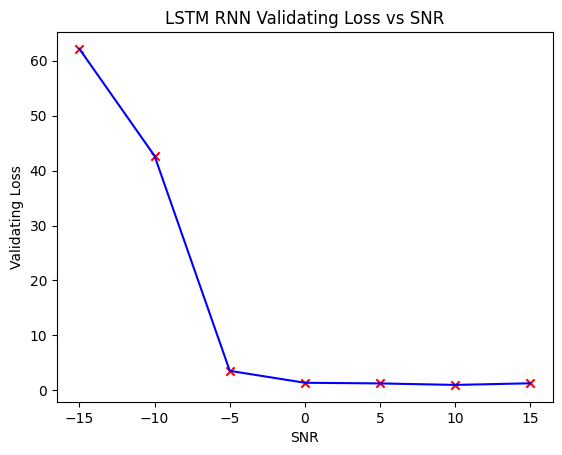

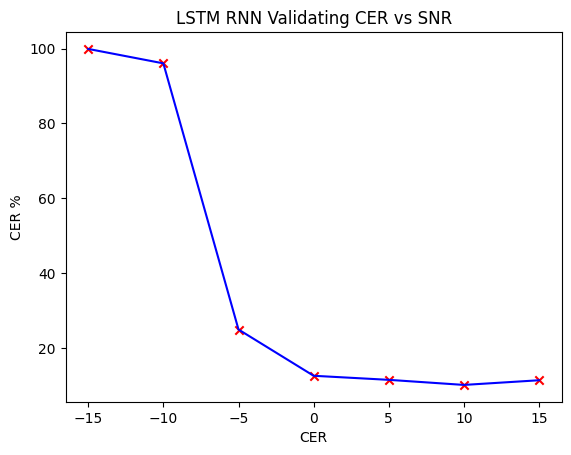

In [166]:
plt.plot(snrs, val_losses, color='blue')
plt.scatter(snrs, val_losses, marker='x', color='red')
plt.xlabel('SNR')
plt.ylabel('Validating Loss')
plt.title('LSTM RNN Validating Loss vs SNR')
plt.show()

plt.plot(snrs, [100*c for c in cers], color='blue')
plt.scatter(snrs, [100*c for c in cers], marker='x', color='red')
plt.xlabel('CER')
plt.ylabel('CER %')
plt.title('LSTM RNN Validating CER vs SNR')
plt.show()

## Detection: Faster R-CNN
Faster R-CNN (Faster Regions with Convolutional Neural Networks) is an object detection algorithm that builds upon the success of its predecessors, R-CNN and Fast R-CNN. It was introduced in the 2015 paper ["Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks"](https://arxiv.org/abs/1506.01497) by Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun.

The key innovation in Faster R-CNN is the introduction of a **Region Proposal Network** (RPN), which is a fully convolutional network that generates region proposals (bounding boxes) for objects in the input image. This contrasts with previous approaches that relied on external region proposal algorithms like selective search, which were computationally expensive and slow.

The Faster R-CNN architecture consists of two main components:

1. **Region Proposal Network (RPN)**: This is a lightweight convolutional neural network that takes an input image and outputs a set of object proposals or regions of interest (RoIs). The RPN works by sliding a small window over the input feature map and outputting multiple region proposals for each window location. These proposals are then filtered and ranked based on their objectness score, which is the probability that a region contains an object of interest.

2. **Object Detection Network**: This is a Fast R-CNN network that takes the proposed RoIs from the RPN and performs object classification and bounding box regression. It extracts features from each RoI using a RoI pooling layer and then passes these features through fully connected layers to predict the class and refine the bounding box coordinates.

The key advantages of Faster R-CNN are:

1. **Speed**: By integrating the region proposal step into the network, Faster R-CNN can process images much faster than its predecessors, enabling real-time object detection.
2. **Accuracy**: The RPN and the shared convolutional features used for both region proposal and object detection improve the overall accuracy of the system.
3. **End-to-End Training**: The entire Faster R-CNN network can be trained end-to-end, making the training process more efficient and effective.

Faster R-CNN has been widely adopted and has inspired numerous subsequent object detection algorithms, such as Mask R-CNN for instance segmentation and RetinaNet for dense object detection.

We will use 'fasterrcnn_resnet50_fpn' varient (original model), read more here ["PyTorch FASTER R-CNN"](https://pytorch.org/vision/0.16/models/faster_rcnn.html)

### Utils

In [213]:
def spectrum_to_img(spec):
    '''
    Transform spectrum to grey-image, ready for training in resnet50 model
    
    :param spec: ndarray (shape: [H, W])
    :return: normalized torch image (shape: [1, H, W])
    '''
    # Normalize the spectrum (min-max scaling)
    min_value = np.min(spec)
    max_value = np.max(spec)
    normalized_spectrum = (spec - min_value) / (max_value - min_value)

    # Adapt dimension for resnet50
    normalized_spectrum = np.expand_dims(normalized_spectrum, axis=-1)
    normalized_spectrum = torch.from_numpy(normalized_spectrum).permute(2,0,1)

    return normalized_spectrum


def get_training_sample_bbx(*args, **kwargs):
    '''
    Used in NN dataset to generate sample with bounding box of the morse content
    :param args: generate_morse_sample args
    :param kwargs: 
    :return: torch image (shape: [1, H, W]) and bounding box (list[x_start, y_start, x_end, y_end])
    '''
    _, spec, morse_str, bbx = generate_morse_sample(*args, **kwargs)
    spec = spectrum_to_img(spec)

    return spec, bbx, morse_str


def inference(img, model_, detection_threshold=0.5):
    '''
    Infernece of a single input image from resnet

    inputs:
      img: input-image as torch.tensor (shape: [C, H, W])
      model: model for infernce (torch.nn.Module)
      detection_threshold: Confidence-threshold for NMS (default=0.7)

    returns:
      boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
      labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
      scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
    '''
    model_.eval()

    img = img.to(device)
    outputs = model_([img])

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    labels = labels[scores >= detection_threshold]
    scores = scores[scores >= detection_threshold]

    return boxes, scores, labels


def plot_image(img, boxes, scores, labels, dataset, morse_str, save_path=None):
    '''
    Function that draws the BBoxes, scores, and labels on the image.

    inputs:
      img: input-image as numpy.array (shape: [H, W, C])
      boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
      scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
      labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
      dataset: list of all classes ["background", "morse"] => Format [N_classes]
    '''
    # Preprocessing
    img = img.permute(1,2,0).numpy()
    img = np.squeeze(img, axis=-1)
    class_labels = np.array(dataset)

    # Plotting
    fig, ax = plt.subplots(1, figsize=(16, 8))
    plt.pcolormesh(img)
    for i, box in enumerate(boxes):

        # BBX
        class_pred = labels[i]
        conf = scores[i]
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2]-box[0],
            box[3]-box[1],
            linewidth=4,
            edgecolor='red',
            facecolor="none",
        )
        ax.add_patch(rect)

        # Add vertical lines
        ax.axvline(x=box[0], color='r', linestyle='--', linewidth=3, alpha=0.5)
        ax.axvline(x=box[2], color='r', linestyle='--', linewidth=3, alpha=0.5)

        # Add the label
        plt.text(
            box[0], box[1],
            s='"' + morse_str + '" | ' + class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
            color="white",
            fontsize=14,
            verticalalignment="top",
            bbox={"color": 'red', "pad": 0},
        )

    # Used to save inference phase results
    if save_path is not None:
        plt.savefig(save_path)

    plt.show()


def collate_fn(batch):
    return tuple(zip(*batch))

### Generate and Plot 1 example

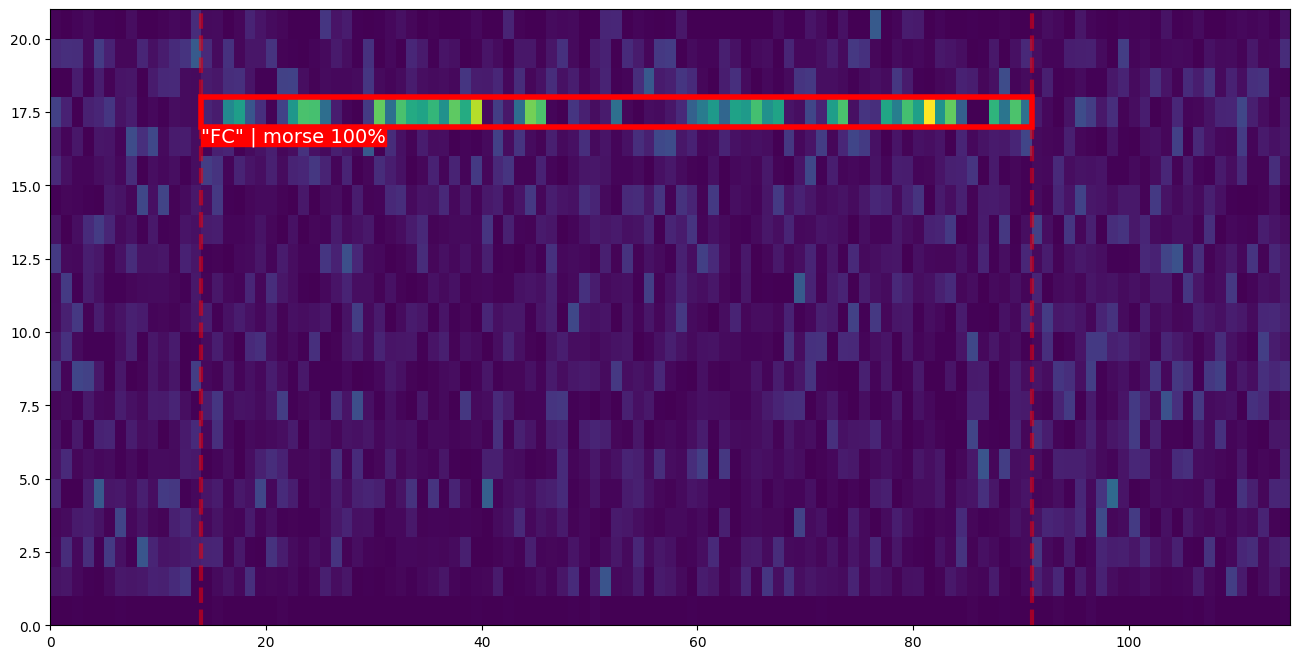

In [47]:
sr = 2000

# Random params
length = random.randrange(1, 7)
pitch = random.randint(2, 19) * 50
wpm = 18
snrDB = random.randrange(-10, 10)
amplitude = random.randrange(50, 200)

# Generate
spec, bbx, morse_str = get_training_sample_bbx(sr, length, pitch, wpm, snrDB, amplitude)

# Plot
plot_image(spec, [bbx], [1.0], [1], ['background', 'morse'], morse_str)

### Dataset

In [48]:
class DatasetBBX(data.Dataset):
    """
    Custom PyTorch dataset for bounding box detection task in morse
    Generates data samples in runtime
    """
    def __init__(self, number_of_samples=4096, sr=2000, explicit_snr=None):
        self.length = number_of_samples
        self.sr = sr
        self.explicit_snr=explicit_snr

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        target = {}

        # Generate random parameters for the sample
        length = random.randrange(1, 8)
        pitch = random.randint(2, 19) * 50
        wpm = 18
        amplitude = random.randrange(50, 200)
        if self.explicit_snr != None:
            snrDB = self.explicit_snr
        else:
            snrDB = random.randrange(-10, 10)

        spec, bbx, _ = get_training_sample_bbx(self.sr, length, pitch, wpm, snrDB, amplitude, None, True)

        # Store the bounding box and label in the target dictionary
        target["boxes"] = torch.Tensor([bbx]).float()
        target["labels"] = torch.LongTensor([1])

        return spec, target

### Training

#### Hyperparameter

In [49]:
SEED = 42
NUM_EPOCHS = 50
LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.001
LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1
BATCH_SIZE = 64
NUM_TEST_IMAGES = 5
OUTPUT_DIR = 'faster_rnn_outputs'

#### Model init

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Classes
labels = ['background', 'morse']
num_classes = len(labels)

# Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=50, max_size=550) # 1 up to 9 morse chars max img size is ~550
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)

# Dataset
dataset = DatasetBBX()
dataset_test = DatasetBBX()
torch.manual_seed(SEED)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_SCHED_STEP_SIZE, gamma=LR_SCHED_GAMMA)

# data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    # num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    # num_workers=4,
    collate_fn=collate_fn)

#### Training functions

In [51]:
def train_one_epoch(model, optimizer, data_loader, device):
    '''
    train the model over one epoch.
    '''
    train_loss_list = []
    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    
    for idx, data in enumerate(tqdm_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

        losses = model(images, targets)
        loss = sum(loss for loss in losses.values())
        train_loss_list.append(loss.detach().cpu().numpy())

        loss.backward()
        optimizer.step()
        tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

    return train_loss_list


def evaluate(model, data_loader_test, device):
    '''
    validate the model
    '''
    val_loss_list = []
    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)
        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        
        val_loss_list.append(loss_val)
        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
        
    return val_loss_list


def plot_loss(train_loss, valid_loss):
    '''
    plot training and valdiation losses and save them in `output_dir'
    '''
    
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

#### Load checkpoint
epoch 541 checkpoint available at: https://we.tl/t-Bk8Sfvh2bR [320 MB]

In [197]:
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last checkpoint file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': []}

In [198]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
log.info(f"Total number of parameters: {total_params}")

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log.info(f"Number of trainable parameters: {trainable_params}")

2024-04-02 10:23:56 [INFO] root - Total number of parameters: 41299161
2024-04-02 10:23:56 [INFO] root - Number of trainable parameters: 41076761


#### Train

In [ ]:
for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    log.info("----------Epoch {}----------".format(epoch+1))

    # Train the model for one epoch
    train_loss_list = train_one_epoch(model, optimizer, data_loader, device)
    loss_dict['train_loss'].extend(train_loss_list)

    lr_scheduler.step()

    # Run evaluation
    valid_loss_list = evaluate(model, data_loader_test, device)
    loss_dict['valid_loss'].extend(valid_loss_list)

    if epoch % 10 == 0:
        # Save model
        ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_dict': loss_dict
        }, ckpt_file_name)

    plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

log.info("Training Finished !")

### Evaluate

In [54]:
def IoU_loss_x_axis_only(pred_box, gt_box):
    """
    Calculates modified Intersection-over-Union loss considering only x-axis overlap.
  
    Args:
        pred_boxes: numpy array of predicted bounding boxes (format: [x1, y1, x2, y2])
        gt_boxes: numpy array of ground truth bounding boxes (same format)
  
    Returns:
        Modified IoU loss (float)
    """
    # Calculate overlap width
    overlap_width = np.maximum(0, np.minimum(pred_box[2], gt_box[2]) - np.maximum(pred_box[0], gt_box[0]))

    # Union width based on wider box (modify as needed)
    union_width = np.maximum(pred_box[2] - pred_box[0], gt_box[2] - gt_box[0])

    # Calculate modified IoU loss (1 - IoU_x)
    iou_loss = 1.0 - np.mean(overlap_width / np.maximum(union_width, 1e-10))
    return iou_loss

2024-04-02 10:26:01 [INFO] root - IoU-x loss = 0.05405405405405406


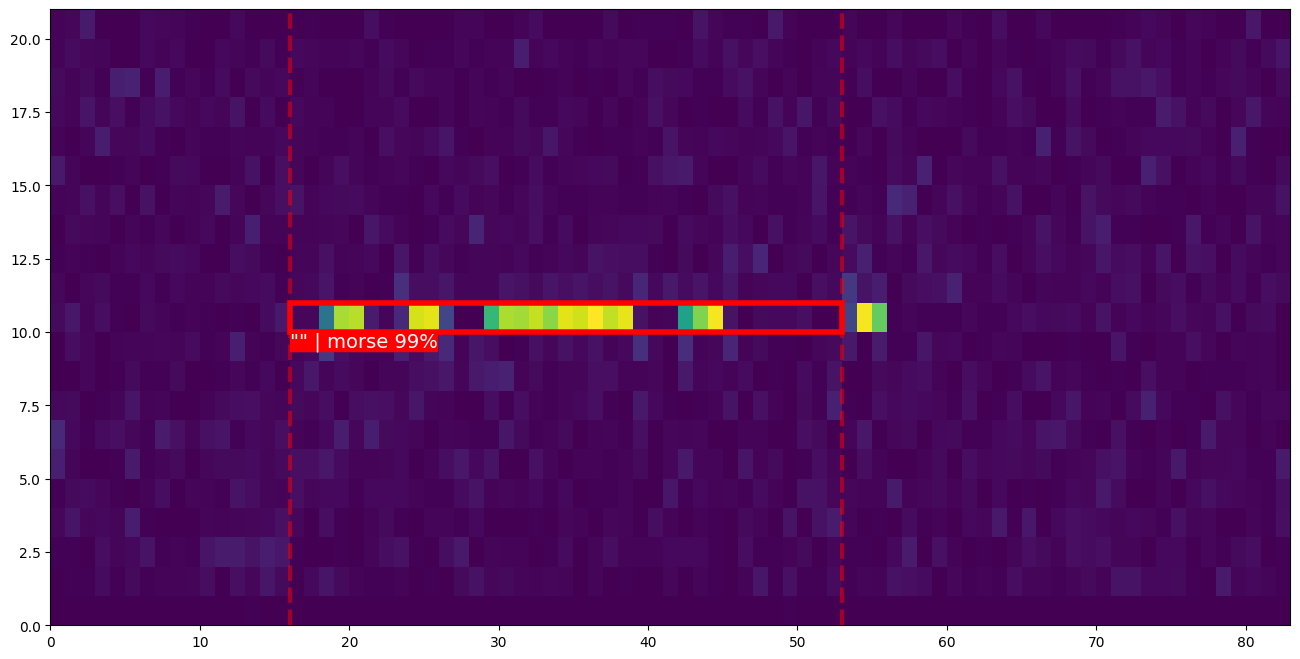

Final IoU-x loss = 0.05405405405405406


In [210]:
random.seed(SEED)
num_images = NUM_TEST_IMAGES

plot = True
num_of_samples = 1

eval_loss = []
model.eval()
for i in range(num_of_samples):
    x = random.randint(0, (dataset_test.__len__()-1))
    img, target = dataset_test.__getitem__(x)
    img = img.to(device)
    box, scores, labels = inference(img, model)
    if len(box) > 0:
        iou_loss = IoU_loss_x_axis_only(box[0], target["boxes"][0].numpy())
    else:
        iou_loss = 1.0
    eval_loss.append(iou_loss)
    if plot:
        log.info(f'IoU-x loss = {iou_loss}')
        plot_image(img.cpu(), box, scores, labels, ['background', 'morse'],'')
print(f'Final IoU-x loss = {np.mean(eval_loss)}')

In [153]:
# per SNR
snrs = [-15, -10, -5, 0, 5, 10, 15]
ious = []
num_of_samples = 1000

for i in range(len(snrs)):
    log.info(f'Evaluating model for snr: {snrs[i]}')

    dataset_test = DatasetBBX(explicit_snr=snrs[i])    
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False,
        collate_fn=collate_fn)

    eval_loss = []
    model.eval()
    for i in range(num_of_samples):
        x = random.randint(0, (dataset_test.__len__()-1))
        img, target = dataset_test.__getitem__(x)
        img = img.to(device)
        box, scores, labels = inference(img, model)
        if len(box) > 0:
            iou_loss = IoU_loss_x_axis_only(box[0], target["boxes"][0].numpy())
        else:
            iou_loss = 1.0
        eval_loss.append(iou_loss)

    ious.append(np.mean(eval_loss))

2024-03-31 19:59:52 [INFO] root - Evaluating model for snr: -15


C:\Users\Maor\AppData\Local\Temp\ipykernel_31128\3015226362.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  time_domain_signal = time_domain_signal.astype(np.float32)


2024-03-31 20:00:27 [INFO] root - Evaluating model for snr: -10
2024-03-31 20:01:00 [INFO] root - Evaluating model for snr: -5
2024-03-31 20:01:39 [INFO] root - Evaluating model for snr: 0
2024-03-31 20:02:13 [INFO] root - Evaluating model for snr: 5
2024-03-31 20:02:48 [INFO] root - Evaluating model for snr: 10
2024-03-31 20:03:23 [INFO] root - Evaluating model for snr: 15


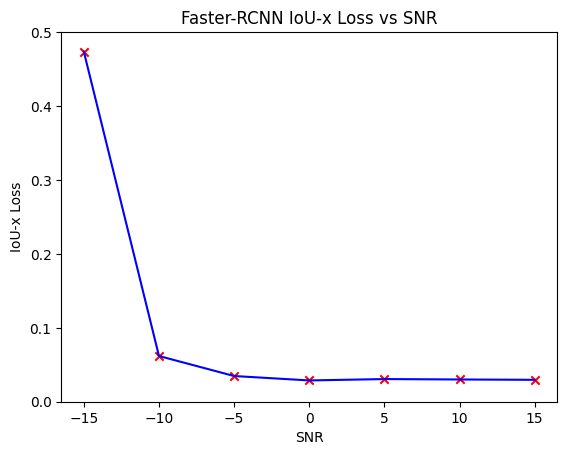

In [159]:
plt.plot(snrs, ious, color='blue')
plt.scatter(snrs, ious, marker='x', color='red')
plt.xlabel('SNR')
plt.ylabel('IoU-x Loss')
plt.title('Faster-RCNN IoU-x Loss vs SNR')
plt.ylim(0, 0.5)
plt.show()

# Demo
Example on how we can use both models - one for decoding the morse information, and the other for detecting morse in the frame

## Utils

In [93]:
def plot_decode_detect(img, boxes, scores, labels, dataset, original_str, predicted_str):
    '''
    Function that draws the BBoxes, scores, and labels on the image.

    inputs:
      img: input-image as numpy.array (shape: [H, W, C])
      boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
      scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
      labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
      dataset: list of all classes ["background", "morse"] => Format [N_classes]
    '''
    # Preprocessing
    img = img.permute(1,2,0).numpy()
    img = np.squeeze(img, axis=-1)
    class_labels = np.array(dataset)

    # Plotting
    fig, ax = plt.subplots(1, figsize=(16, 8))
    plt.pcolormesh(img)
    for i, box in enumerate(boxes):
        # box[1] += 1
        # box[3] += 1
        
        # BBX
        class_pred = labels[i]
        conf = scores[i]
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2]-box[0],
            box[3]-box[1],
            linewidth=4,
            edgecolor='red',
            facecolor="none",
        )
        ax.add_patch(rect)

        # Add vertical lines
        ax.axvline(x=box[0], color='r', linestyle='--', linewidth=3, alpha=0.5)
        ax.axvline(x=box[2], color='r', linestyle='--', linewidth=3, alpha=0.5)

        # Add the label
        plt.text(
            box[0], box[1],
            s='predicted <' + predicted_str + '> ' + class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
            color="white",
            fontsize=14,
            verticalalignment="top",
            bbox={"color": 'red', "pad": 0},
        )
        plt.text(
            box[0], box[3],
            s='target <' + original_str + '>',
            color="white",
            fontsize=14,
            verticalalignment="bottom",
            bbox={"color": 'darkred', "pad": 0},
        )

    plt.show()
    
    
def spec_to_lstm(spec):
    spec_ = torch.from_numpy(spec)
    spec_ = spec_.permute(1, 0)
    return spec_

## init models

In [212]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# init decoder
run_date = '2024-03-26_01-45-23'
# run_date = '2024-03-31_23-29-30'
epoch = 3950
spectrogram_size = generate_morse_sample(sr=2000)[1].shape[0]
model_lstm = LSTMRnn(num_tags, spectrogram_size).to(device)
model_lstm.load_state_dict(torch.load(f"models/{run_date}_{epoch:06}.pt", map_location=device))
model_lstm.eval()
print(f"models/{run_date}_{epoch:06}.pt")

# init detector
labels = ['background', 'morse']
num_classes = len(labels)
model_resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=50, max_size=550) # 1 up to 9 morse chars max img size is ~550
in_features = model_resnet.roi_heads.box_predictor.cls_score.in_features
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
checkpoint_files.sort()
latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])
checkpoint = torch.load(latest_checkpoint)
model_resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model_resnet.to(device)
print(latest_checkpoint)

models/2024-03-26_01-45-23_003950.pt
faster_rnn_outputs\epoch_541_model.pth


## Generate, Decode & Detect

2024-04-02 11:20:29 [INFO] root - pitch: 950, wpm: 18, snrDB: 9, amplitude: 245, str: TAL, bbx: (17, 19, 90, 20)


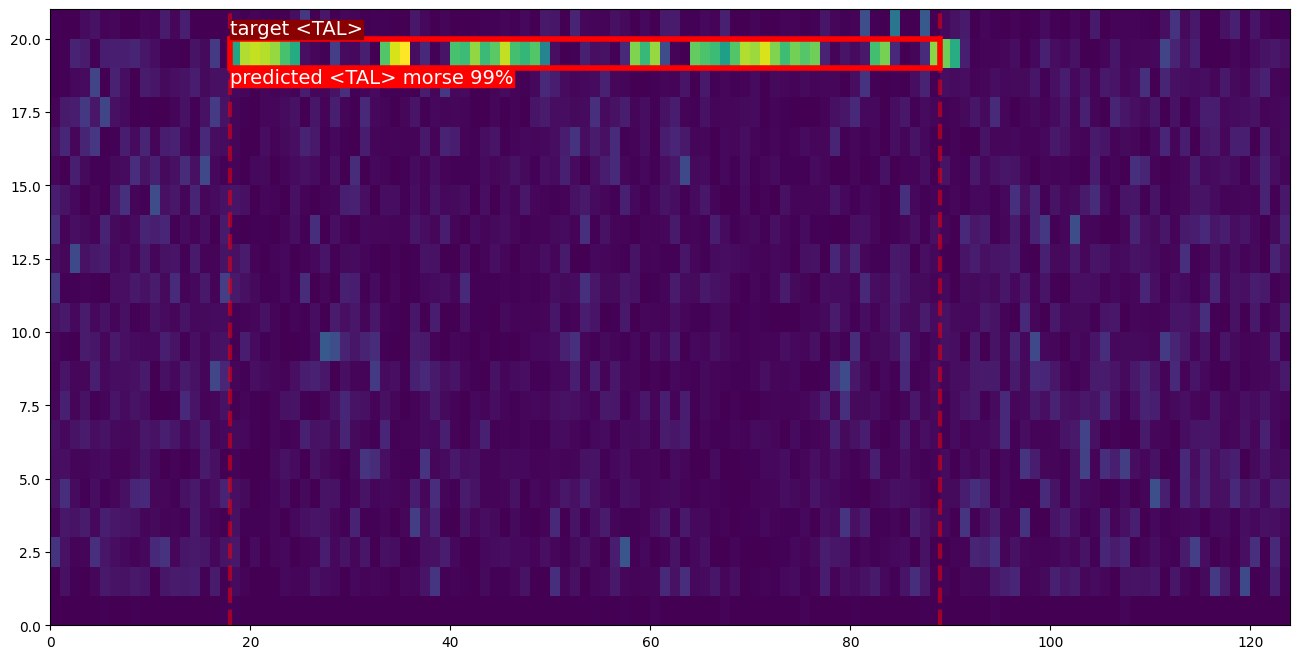

In [222]:
# Params
# ----------------------------------------------------------------
sr = 2000
length = random.randrange(1, 7)
pitch = 950 # random.randint(2, 19) * 50
wpm = 18
snrDB = random.randrange(-5, 10)
amplitude = random.randrange(100, 300)

# Generate random morse sample
# ----------------------------------------------------------------
time_domain_signal, spec, target_str, bbx = generate_morse_sample(sr, length, pitch, wpm, -5, amplitude, "TAL")
log.info(f"pitch: {pitch}, wpm: {wpm}, snrDB: {snrDB}, amplitude: {amplitude}, str: {target_str}, bbx: {bbx}")

# Decode
# ----------------------------------------------------------------
spec_lstm = torch.from_numpy(spec).permute(1, 0).unsqueeze(0).to(device) # preprocess for lstm
with torch.no_grad():
    y_pred_lstm = model_lstm(spec_lstm)
predicted_str = prediction_to_str(torch.argmax(y_pred_lstm[0], 1))

# Detect
# ----------------------------------------------------------------
spec_frnn = spectrum_to_img(spec) # preprocess for faster-rcnn
with torch.no_grad():
    bbx, scores, labels = inference(spec_frnn, model_resnet)

# Plot
# ----------------------------------------------------------------
plot_decode_detect(spec_frnn.cpu(), bbx, scores, labels, ['background', 'morse'], predicted_str, target_str)

# Other stuff

## For Kaggle \ Colab

In [ ]:
# Free space in Kaggle
import os

for the_file in os.listdir('/kaggle/working/faster_rnn_outputs'):
    if the_file != 'epoch_50_model.pth' and the_file != 'loss_dict.pkl':
        os.unlink(os.path.join('/kaggle/working/faster_rnn_outputs', the_file))

In [ ]:
# Move files from input to output in Kaggle
import shutil

src_path = r"/kaggle/input/faster-rnn-epoch-50/epoch_50_model.pth"
dst_path = r"/kaggle/working/faster_rnn_outputs/"

shutil.copy(src_path, dst_path)
print('Copied')

In [14]:
# Mount google drive in Colab
from google.colab import drive

drive.mount('/content/drive')